In [1]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))

plotSurv <- function(fit, data.df, legend.title, legend.labs){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Months)",
        break.time.by = 100,
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
    )
    
    return(p)
}

Warning message:
“package ‘checkmate’ was built under R version 4.3.2”


In [2]:
data.df <- read.table("data/processed/dataset_processed.tsv", sep="\t", header=T)

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

### 1a. Cox Regression w/ Full Dataset
---

In [67]:
cox_model <- coxph(Surv(time, status) ~ Amyloid_type + LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR + Primary_organ + BU.Cardiac.Stage, data=data.filt.df)
obj <- ggforest(cox_model)
ggsave("figures/full_dataset_coxph_forest.pdf", plot = obj, width = 8, height = 10)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


### 1b. Survival Curves w/ Full Dataset
---

In [33]:
fit <- survfit(Surv(time, status) ~ Amyloid_type, data=data.df)

pdf("figures/full_dataset_surv_amyloid_type.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Amyloid",legend.labs=c("AL", "B-cell", "MM", "WM"))
dev.off()

pdf 
  2

In [36]:
dat.df <- data.df[data.df$BU.Cardiac.Stage %in% c("stage I","stage II","stage III","stage IIIb"),]

fit <- survfit(Surv(time, status) ~ BU.Cardiac.Stage, data=dat.df)

pdf("figures/full_dataset_surv_bustage.pdf", width=6, height=6)
plotSurv(fit, dat.df, "BU Staging", c("stage I","stage II","stage III","stage IIIb"))
dev.off()

pdf 
  2

### 2a. Cox Regression w/ AL Dataset
---

* Using `mice` imputed dataset to `consensusClusterPlus`

In [16]:
data.df <- read.table("data/processed/AL_with_ccp_v2_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$agg_clust_3 <- factor(data.df$agg_clust_3, levels=c("Low","Intermediate","High"))
data.df$agg_clust_4 <- factor(data.df$agg_clust_4, levels=c("Low","Low-Intermediate","Intermediate","High"))
data.df$cluster <- factor(data.df$cluster, levels=c("Low","Intermediate","High"))

data.filt.df <- data.df[complete.cases(data.df[,"agg_clust_3"]),]

In [24]:
cox_model <- coxph(Surv(time, status) ~ agg_clust_3*Primary_organ, data=data.filt.df)
summary(cox_model)


Call:
coxph(formula = Surv(time, status) ~ agg_clust_3 * Primary_organ, 
    data = data.filt.df)

  n= 1818, number of events= 1160 
   (256 observations deleted due to missingness)

                                                     coef exp(coef) se(coef)
agg_clust_3Intermediate                          -0.07999   0.92312  0.53268
agg_clust_3High                                  -0.22556   0.79807  0.54805
Primary_organcardiac                             -0.69786   0.49765  0.46431
Primary_organgi                                  -1.59398   0.20311  0.49615
Primary_organhepatic                             -0.77883   0.45894  0.48491
Primary_organother                               -1.38974   0.24914  0.58600
Primary_organpns                                 -0.92912   0.39490  0.52180
Primary_organpulm                                -1.52791   0.21699  0.67114
Primary_organrenal                               -1.33161   0.26405  0.45707
Primary_organsoft_tissue                      

In [18]:
cox_model <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage, data=data.filt.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_forest.pdf", plot = obj, width = 8, height = 10)

cox_model <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR  + BU.Cardiac.Stage + cluster, data=data.filt.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust_forest.pdf", plot = obj, width = 7, height = 8)

cox_model <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR + BU.Cardiac.Stage + agg_clust_3, data=data.filt.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_agg_clust_3_forest.pdf", plot = obj, width = 7, height = 8)

cox_model <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + 
                   Race + Troponin + eGFR + BU.Cardiac.Stage + agg_clust_4, data=data.filt.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_agg_clust_4_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”
Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [114]:
# Surv Object
time <- data.filt.df$time
status <- data.filt.df$status
surv.obj <- Surv(time,status)

mod.1 <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + BU.Cardiac.Stage, data = data.filt.df)
mod.2 <- update(mod.1, . ~ . + cluster)
mod.3 <- coxph(Surv(time, status) ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR + Primary_organ + cluster, data = data.filt.df)

In [117]:
concordance.coxph(object = fit4, fit5, fit6)

ERROR: Error in concordance.coxph(object = fit4, fit5, fit6): could not find function "concordance.coxph"


In [113]:
mod.1$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.953970e+05 6.823800e+04 0.000000e+00 7.200000e+01 0.000000e+00 7.411649e-01 
         std 
1.164207e-02

In [115]:
mod.2$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.967280e+05 6.690700e+04 0.000000e+00 7.200000e+01 0.000000e+00 7.462135e-01 
         std 
1.139071e-02

In [116]:
mod.3$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
1.911030e+05 7.368900e+04 0.000000e+00 7.300000e+01 0.000000e+00 7.217099e-01 
         std 
1.245344e-02

In [293]:
# The pairwise U-statistic is an approach to compare models that is more
# statistically sound that ttest of C-statistics
# However, it is intended for validation cohorts and can be prone to overfitting
# Thus, we can bootstrap with replacement to generate a quantile range
library(rms)
library(doMC)

registerDoMC(cores=4)

# Bootstraps
B <- 100
n <- nrow(data.filt.df)

# Sample with replacement
res.boot <- foreach(b=1:B, .combine="c") %dopar% {
    # Get sampling
    s <- sample(n, replace=TRUE)
    ns <- (1:n)[!1:n %in% s]

    # Fit models 
    mod.1 <- coxph(Surv(time, status) ~ Kappa_or_lambda_PCD + Age + Sex + 
                   Race + Troponin + eGFR + Primary_organ + BU__BNP_based__cardiac_staging, 
                   data = data.filt.df, subset=s)
    mod.2 <- update(mod.1, . ~ . + cluster,
                   data=data.filt.df, subset=s)
    
    # Compute Dxy (pairwise comparison for U-statistic)
    rcorrp.cens(predict(mod.1), predict(mod.2), surv.obj[s, ])["Dxy"]
}

# Get mean value and IQR
mean(res.boot)
quantile(res.boot, prob=c(0.05, 0.95))

[1] 0.08281728

5%        95% 
0.02536588 0.15161717

In [290]:
#Bootstrapped value
B <- 100
n <- nrow(data.filt.df)

# bootstrap with testing on samples not selected in current rep
res.boot <- foreach(b=1:B, .combine="c") %dopar% {
    cat("rep", b, "\n")

    s <- sample(n, replace=TRUE)
    ns <- (1:n)[!1:n %in% s]

    mod.1 <- coxph(Surv(time, status) ~ Kappa_or_lambda_PCD + Age + Sex + Race + Troponin + eGFR + Primary_organ + BU__BNP_based__cardiac_staging, 
                   data = data.filt.df, subset=s)
    mod.2 <- update(mod.1, . ~ . + cluster,
                   data=data.filt.df, subset=s)
    
    mod.1$concordance[[6]]
}

mean(res.boot)
quantile(res.boot, prob=c(0.025, 0.975))

[1] 0.745277

2.5%     97.5% 
0.7218104 0.7661936

In [242]:
rcorrp.cens(predict(mod.1), predict(mod.2), surv.obj)

Dxy               S.D. x1 more concordant x2 more concordant 
      5.438201e-02       2.622517e-02       5.271910e-01       4.728090e-01 
                 n            missing         uncensored     Relevant Pairs 
      1.000000e+03       0.000000e+00       4.970000e+02       5.272700e+05 
         Uncertain               C X1               C X2             Dxy X1 
      4.715860e+05       2.588351e-01       2.547727e-01      -4.823297e-01 
            Dxy X2 
     -4.904546e-01

In [243]:
rcorrp.cens(predict(mod.1), predict(mod.3), surv.obj)

Dxy               S.D. x1 more concordant x2 more concordant 
     -4.741973e-01       2.334809e-02       2.629014e-01       7.370986e-01 
                 n            missing         uncensored     Relevant Pairs 
      1.000000e+03       0.000000e+00       4.970000e+02       5.272700e+05 
         Uncertain               C X1               C X2             Dxy X1 
      4.715860e+05       2.588351e-01       4.764219e-01      -4.823297e-01 
            Dxy X2 
     -4.715611e-02

In [200]:
rcorrp.cens(predict(mod.1), predict(mod.2), surv.obj, method=1)

Dxy               S.D. x1 more concordant x2 more concordant 
      4.884405e-02       2.620049e-02       5.244220e-01       4.755780e-01 
                 n            missing         uncensored     Relevant Pairs 
      1.000000e+03       0.000000e+00       4.970000e+02       5.272700e+05 
         Uncertain               C X1               C X2             Dxy X1 
      4.715860e+05       2.618848e-01       2.581827e-01      -4.762304e-01 
            Dxy X2 
     -4.836346e-01

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


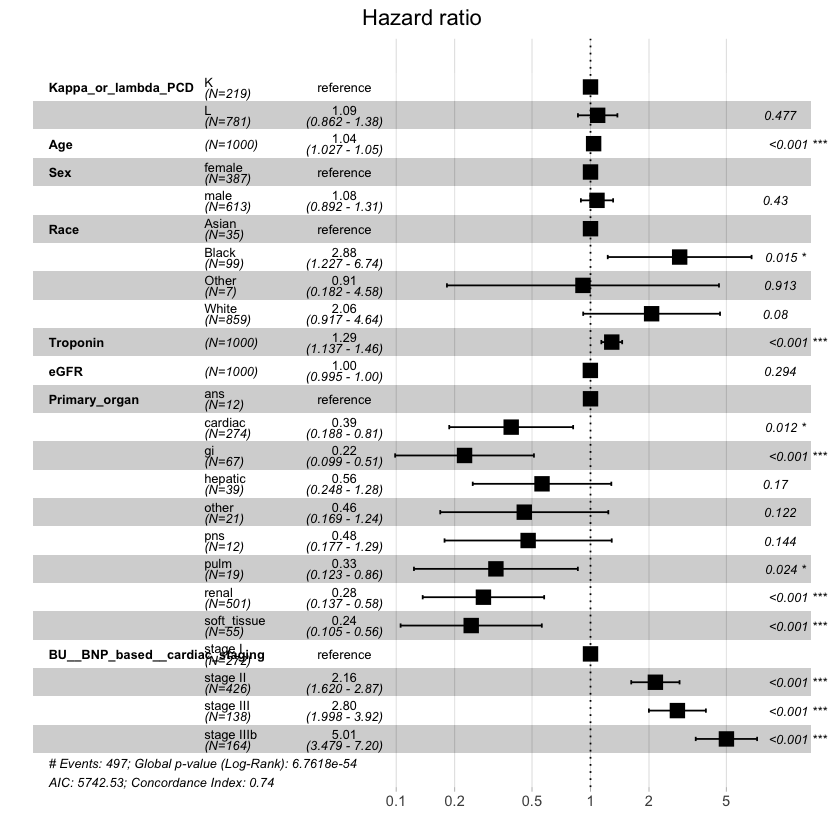

In [295]:
ggforest(mod.1)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


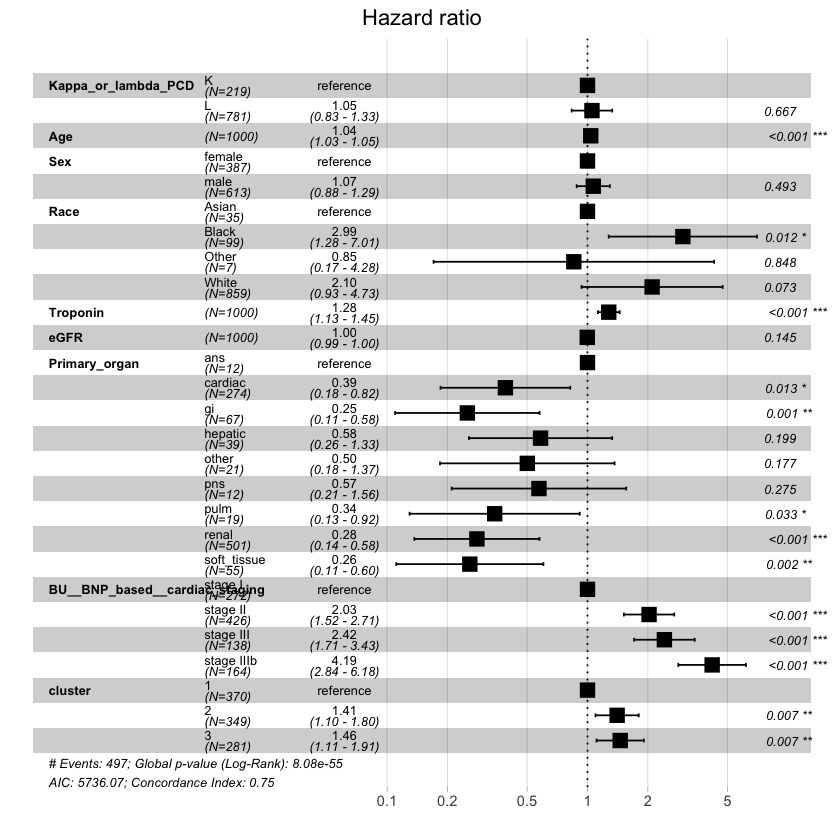

In [296]:
ggforest(mod.2)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


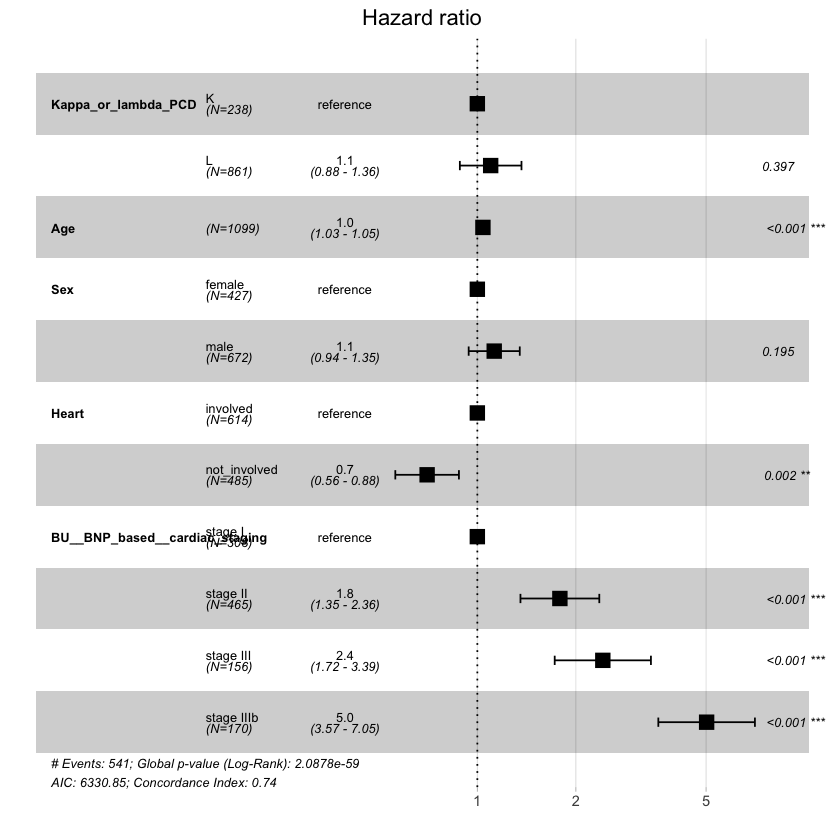

In [30]:
dat.2.df <- dat.df[dat.df$BU__BNP_based__cardiac_staging %in% c("stage I","stage II","stage III","stage IIIb"),]

mod.1 <- coxph(Surv(time, status) ~  Kappa_or_lambda_PCD + Age + Sex + Heart + BU__BNP_based__cardiac_staging, data = dat.2.df)
ggforest(mod.1)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


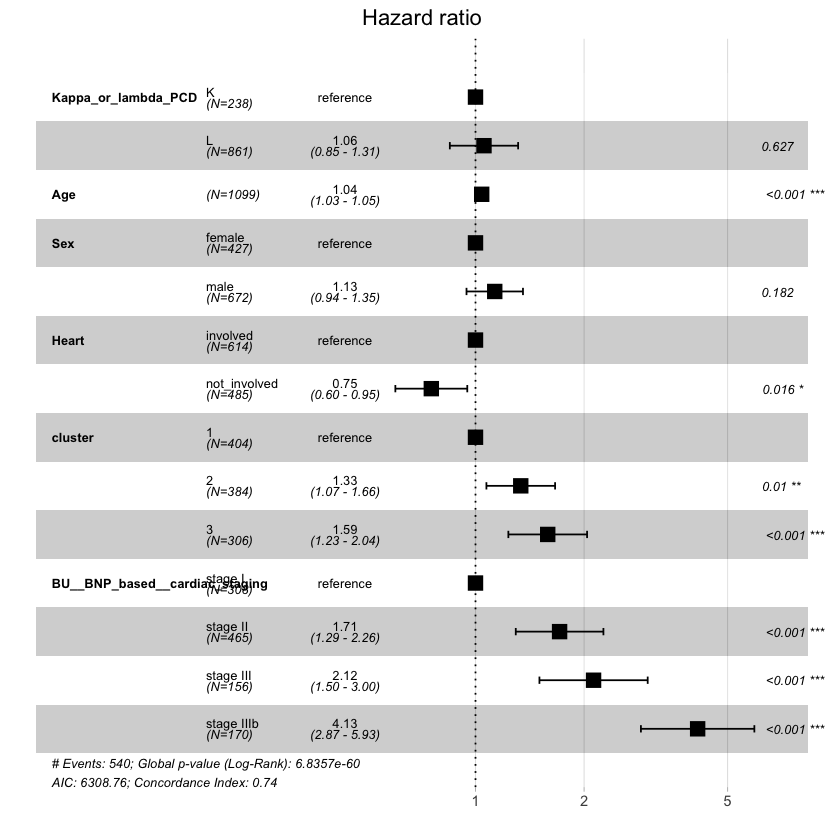

In [31]:
dat.2.df <- dat.df[dat.df$BU__BNP_based__cardiac_staging %in% c("stage I","stage II","stage III","stage IIIb"),]

mod.2 <- coxph(Surv(time, status) ~  Kappa_or_lambda_PCD + Age + Sex + Heart + cluster + BU__BNP_based__cardiac_staging, data = dat.2.df)
ggforest(mod.2)

In [32]:
pred_prob1 <- predict(mod.1, newdata = dat.df, type = "lp", se.fit = TRUE)

ERROR: Error in model.frame.default(data = dat.df, formula = ~Kappa_or_lambda_PCD + : factor Heart has new levels equivocal


### 2b. Survival
---

In [14]:
data.filt.df

,Code.ID,Date_of_admission_to_center,Date_of_birth,Date_of_diagnosis,Date_of_death,Date_of_last_visit,Cardiopulmonary_symptom_onset,Renal_signs_symptom_onset,Neurologic_symptom_onset,Amyloid_type,⋯,Floors_climbed,Distance_walked,Systolic_BP_sitting,Diastolic_BP_sitting,Pulse_sitting,eGFR,status,time,Era,cluster
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<fct>
2,6102,1996-12-16,1944-03-20,1996-11-08,2017-01-28,2012-08-27,,1996-05-15,,AL,⋯,NA,NA,NA,NA,NA,66.099007,1,246.200000,Era_1-2,1
3,9338,1994-07-11,1933-12-21,1993-06-24,1997-08-02,1997-03-24,,1993-03-15,,AL,⋯,NA,NA,150,92,88,40.134290,1,50.000000,Era_1-2,2
15,9419,1994-07-11,1920-02-06,1994-04-15,1994-08-21,1994-07-11,,1994-01-15,,AL,⋯,NA,NA,128,84,70,27.621757,1,4.266667,Era_1-2,2
17,9421,1994-07-18,1937-04-26,1994-05-04,1995-02-24,1994-07-18,1993-04-15,,,AL,⋯,NA,NA,120,74,68,40.394251,1,9.866667,Era_1-2,3
18,9422,1994-07-25,1948-05-05,1994-05-06,2018-04-10,2001-07-23,1992-12-15,,1994-03-15,AL,⋯,NA,NA,95,62,NA,49.727234,1,291.333333,Era_1-2,3
19,9423,1994-07-25,1936-02-10,1994-06-17,1994-12-01,1994-07-25,,1994-05-15,,AL,⋯,NA,NA,110,64,80,5.467333,1,5.566667,Era_1-2,2
22,9429,1994-09-26,1934-04-15,1994-03-16,1999-02-02,1994-09-26,,1994-02-15,,AL,⋯,NA,NA,170,102,80,9.186347,1,59.466667,Era_1-2,1
23,9431,1994-10-03,1927-07-28,1994-08-26,1995-01-01,1994-10-03,1993-10-15,,,AL,⋯,NA,NA,NA,NA,NA,50.711019,1,4.266667,Era_1-2,1
24,9432,1994-10-17,1923-07-10,1993-02-15,1995-11-13,1994-10-17,,1992-11-15,1994-04-15,AL,⋯,NA,NA,NA,NA,NA,99.742546,1,33.366667,Era_1-2,2


Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
“There are no survival curves to be compared. 
 This is a null model.”


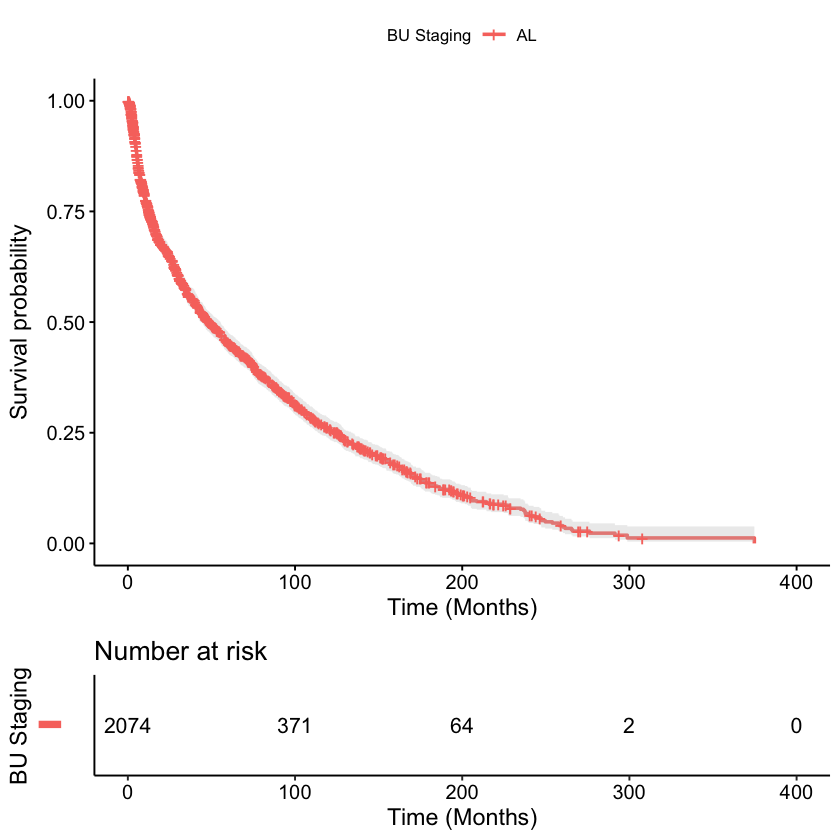

In [13]:
fit <- survfit(Surv(time, status) ~ 1, data=data.filt.df)
plotSurv(fit, data.filt.df, "BU Staging", c("AL"))

In [121]:
fit <- survfit(Surv(time, status) ~ BU.Cardiac.Stage, data=data.filt.df)

pdf("figures/AL_dataset_surv_bustage.pdf", width=6, height=6) 
plotSurv(fit, dat.df, "BU Staging", c("stage I","stage II","stage III","stage IIIb"))
dev.off()

pdf 
  2

In [123]:
fit <- survfit(Surv(time, status) ~ cluster, data=data.filt.df)

pdf("figures/AL_dataset_surv_cluster.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster",legend.labs=c("1", "2", "3"))
dev.off()

pdf 
  2

In [129]:
data.filt.df[data.filt.df$BU.Cardiac.Stage=="stage I",]

,Code.ID,Date_of_admission_to_center,Date_of_birth,Date_of_diagnosis,Date_of_death,Date_of_last_visit,Cardiopulmonary_symptom_onset,Renal_signs_symptom_onset,Neurologic_symptom_onset,Amyloid_type,⋯,Floors_climbed,Distance_walked,Systolic_BP_sitting,Diastolic_BP_sitting,Pulse_sitting,eGFR,status,time,Era,cluster
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<fct>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.7,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.8,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [133]:
fit <- survfit(Surv(time, status) ~ cluster + BU.Cardiac.Stage, 
               data=data.filt.df[data.filt.df$BU.Cardiac.Stage=="stage I",])

pdf("figures/AL_dataset_surv_cluster_stageI.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster / Cardiac Stage", legend.labs=c("1","2","3"))
dev.off()

fit <- survfit(Surv(time, status) ~ cluster + BU.Cardiac.Stage, 
               data=data.filt.df[data.filt.df$BU.Cardiac.Stage=="stage II",])

pdf("figures/AL_dataset_surv_cluster_stageII.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster / Cardiac Stage", legend.labs=c("1","2","3"))
dev.off()

fit <- survfit(Surv(time, status) ~ cluster + BU.Cardiac.Stage, 
               data=data.filt.df[data.filt.df$BU.Cardiac.Stage=="stage III",])

pdf("figures/AL_dataset_surv_cluster_stageIII.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster / Cardiac Stage", legend.labs=c("1","2","3"))
dev.off()

fit <- survfit(Surv(time, status) ~ cluster + BU.Cardiac.Stage, 
               data=data.filt.df[data.filt.df$BU.Cardiac.Stage=="stage IIIb",])

pdf("figures/AL_dataset_surv_cluster_stageIIIb.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster / Cardiac Stage", legend.labs=c("1","2","3"))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

###
---

In [24]:
data.df <- read.table("data/processed/AL_with_ccp_tx_04.tsv", sep="\t", header=T)

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

In [69]:
data.df$cluster <- as.factor(data.df$cluster)

In [78]:
data.filt.df <- data.df[data.df$first_tx %in% c("IMiD-based","Dara-CyBorD","Proteasome inhibitor-based",
                                                "Melphalan-based regimen","Glucocorticoid monotherapy"),]

mod <- coxph(Surv(time, status) ~  cluster + first_tx + cluster*first_tx, data = data.filt.df)
mod

Call:
coxph(formula = Surv(time, status) ~ cluster + first_tx + cluster * 
    first_tx, data = data.filt.df)

                                               coef exp(coef) se(coef)      z
cluster2                                     1.7090    5.5233   1.1181  1.528
cluster3                                     2.3603   10.5938   1.0803  2.185
first_txGlucocorticoid monotherapy           1.8333    6.2545   1.0254  1.788
first_txIMiD-based                           1.0974    2.9962   1.0249  1.071
first_txMelphalan-based regimen              1.5744    4.8276   1.0063  1.565
first_txProteasome inhibitor-based           0.8904    2.4362   1.0122  0.880
cluster2:first_txGlucocorticoid monotherapy -1.5118    0.2205   1.1621 -1.301
cluster3:first_txGlucocorticoid monotherapy -2.0336    0.1309   1.1478 -1.772
cluster2:first_txIMiD-based                 -1.1185    0.3268   1.1637 -0.961
cluster3:first_txIMiD-based                 -1.8243    0.1613   1.1342 -1.609
cluster2:first_txMelphalan-base

In [79]:
data.filt.df <- data.df[data.df$first_tx %in% c("HDM/SCT"),]

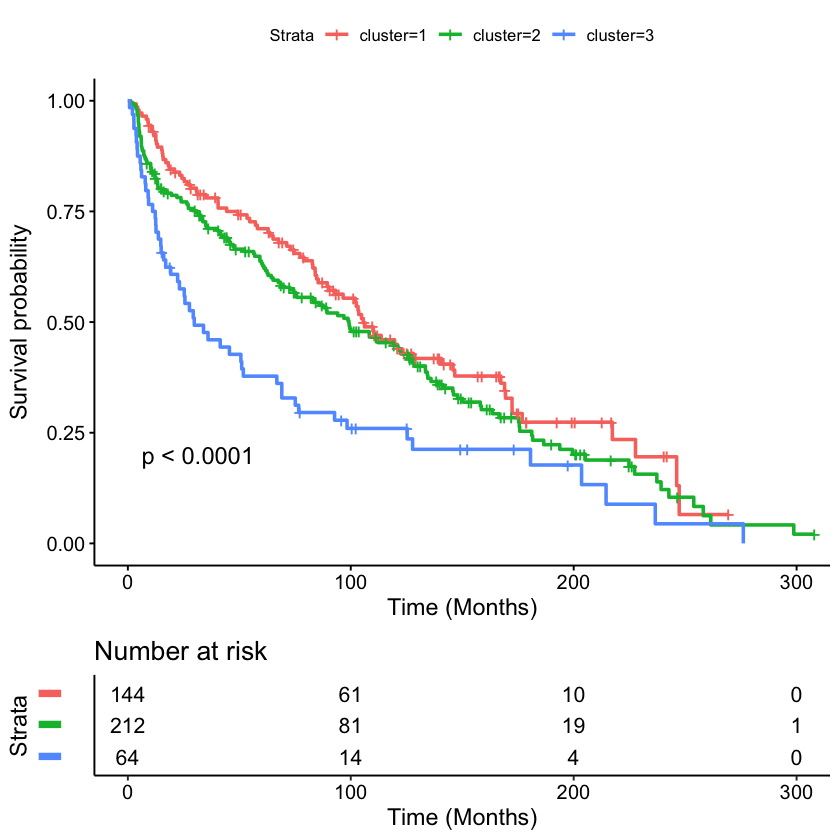

In [81]:
fit <- survfit(Surv(time, status) ~ cluster, data=data.filt.df)

p <- ggsurvplot(
    fit,                    
    data = data.df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = F,
    xlab = "Time (Months)",
    break.time.by = 100,
    risk.table.y.text.col = T,
    risk.table.y.text = F,
)
p